_version log: checking maths by using mock interferogram_

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd

pixel_pitch = 9.9 #um

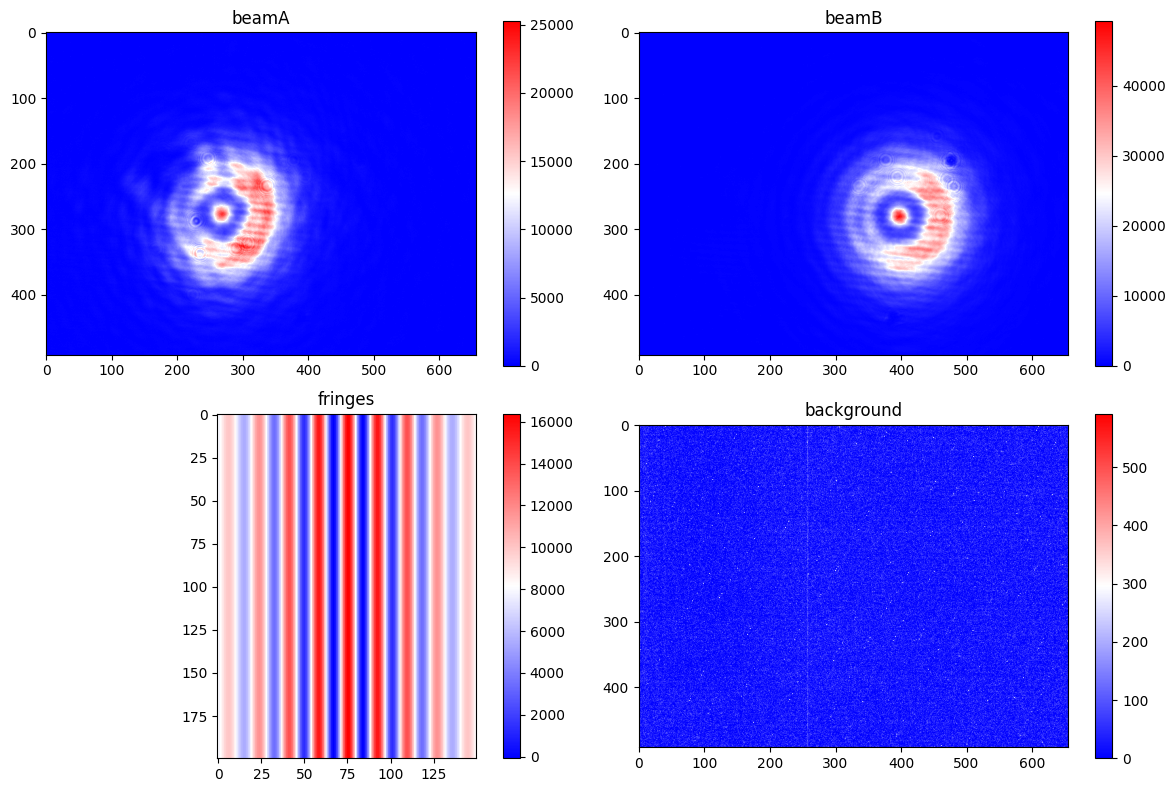

In [26]:
im = Image.open('data\\green_BA3.tif')
beamA = np.array(im, dtype= np.float32)
im = Image.open('data\\green_BB3.tif')
beamB = np.array(im, dtype= np.float32)
im = Image.open('data\\green_fringes3.tif')
fringes = np.array(im, dtype= np.float32)
im = Image.open('data\\green_bg3.tif')
background = np.array(im, dtype= np.float32)

f = open('data\\elin_mock_interferogram.csv', 'rt')
fringes = np.loadtxt(f, skiprows=0, delimiter = ";", dtype = np.float32)
f.close()

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background")

plt.tight_layout()
plt.show()

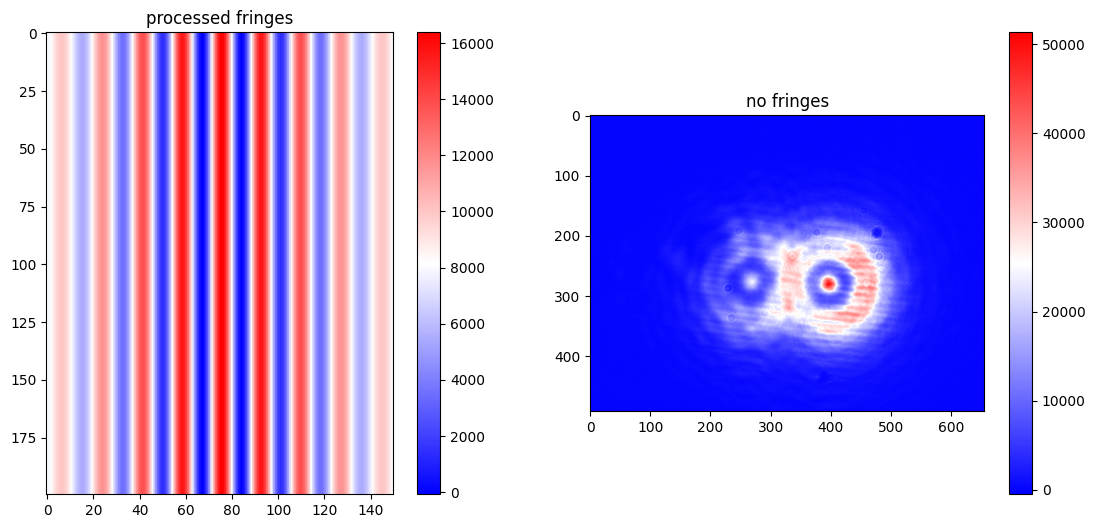

In [27]:
beamPost = fringes

plt.figure(figsize = (14,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

plt.subplot(1,2,2)
im=plt.imshow(nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("no fringes")

plt.show()

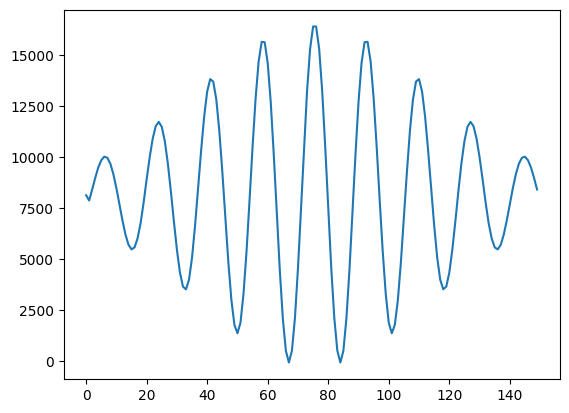

In [28]:
average_signal = np.mean(beamPost, axis = 0)

plt.plot(average_signal)
plt.show()


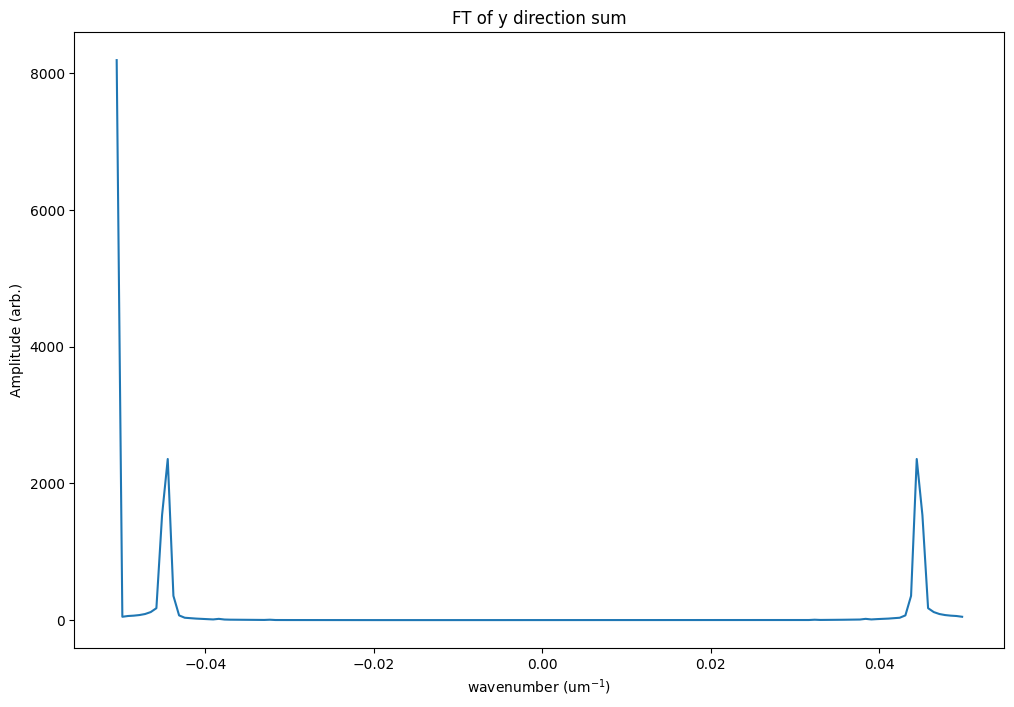

In [29]:
FT = np.fft.fft(average_signal, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.linspace(-1/2/pixel_pitch, 0, num_of_freqs) #niquist frequency = 1/2 * 1/pixel_pitch
freqs = np.concatenate((freqs, -freqs[-2::-1]))
freqs = freqs[:len(FT)]

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(freqs,
        abs(FT))

plt.xlabel('wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')
plt.title("FT of y direction sum")

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_13388\3840372871.py:12: RuntimeWarning: divide by zero encountered in divide
  wavelengths = -1/freqs[:-num_of_freqs +2]


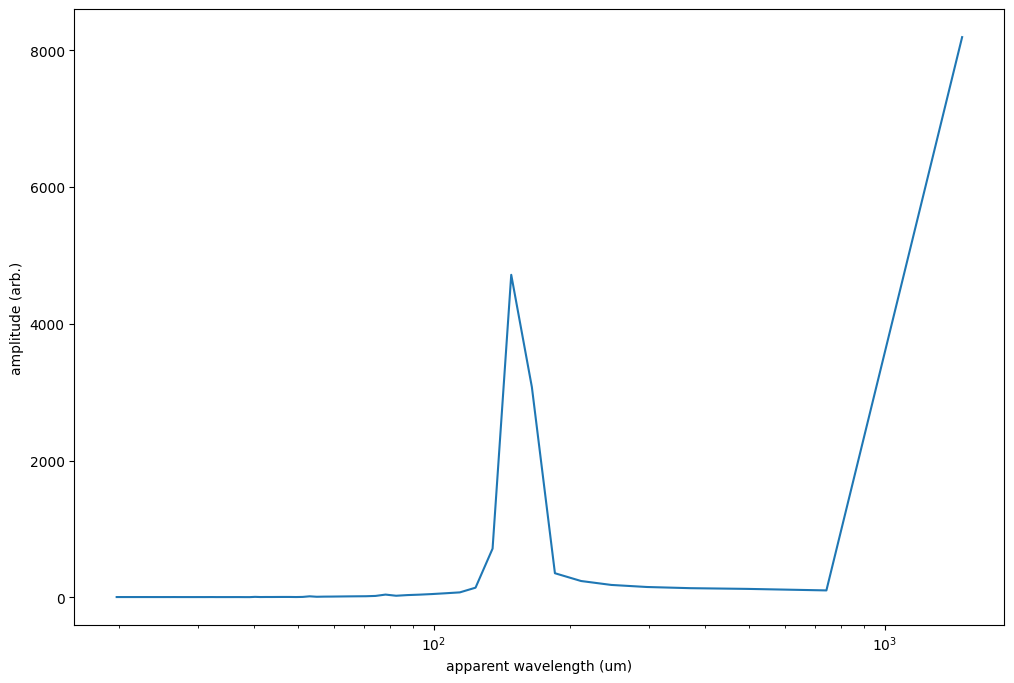

In [30]:
#FT = np.fft.fftshift(FT) #rearranges the array such that 0,0 at the beginning

#assign amplitudes from fft coeffients. Check how elin does this. (She is smarter than me!)
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])

if (samples//2 == samples/2): #if even
        amplitude[num_of_freqs-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))

        wavelengths = -1/freqs[:-num_of_freqs +2]

else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))

        wavelengths = -1/freqs[:-num_of_freqs +1]

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths[:-1], #excule the infinate wavelength
        amplitude[-2::-1]) #the largest wavelength is the smallest frequency so the order needs to be reversed
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")

plt.show()

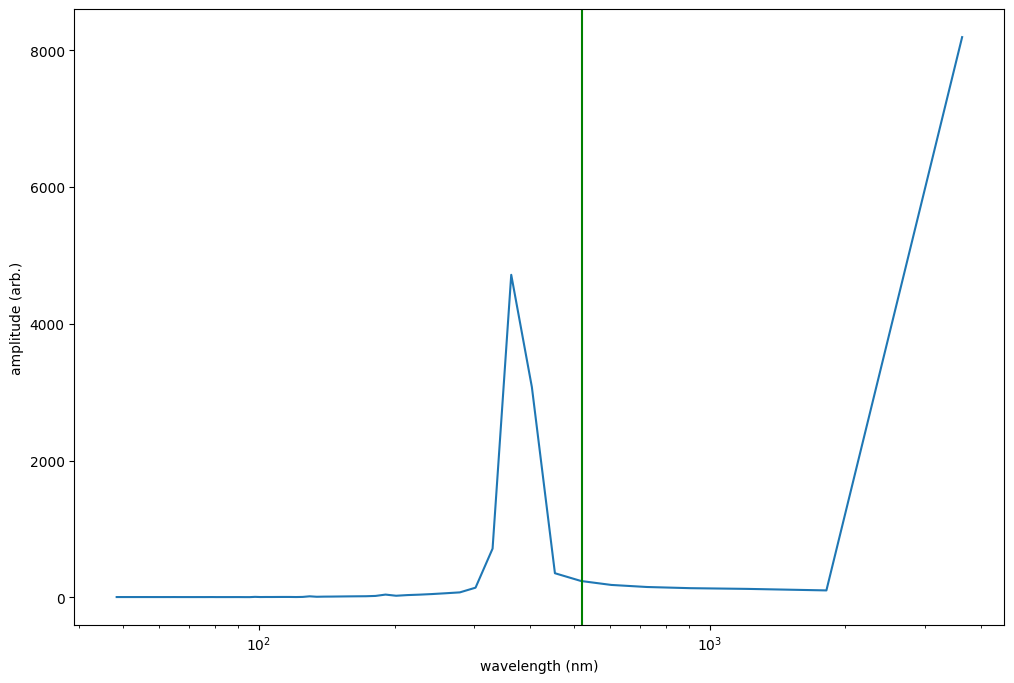

In [31]:
################COMPENSATE FOR ANGLE#################

angle_between_beams = 0.14 # =2*theta. in degrees. Has a large uncertainty

theta = angle_between_beams/2 *np.pi/180 #in radians
corrected_wavelengths = wavelengths *2*np.sin(theta)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(corrected_wavelengths[:-1] *1e3, #excule the infinate wavelength and convert to nm
        amplitude[-2::-1]) #the largest wavelength is the smallest frequency so the order needs to be reversed
plt.xlabel('wavelength (nm)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.axvline(520, color = "green")
plt.show()

In [32]:
#################FINDING LARGEST AMPLITUDES############

df = np.stack([amplitude[::-1],
                corrected_wavelengths])
df = np.transpose(df)

df = pd.DataFrame(df, columns = ["amplitude","wavelength"], dtype = float)
df.sort_values("amplitude", ascending = False, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head(10) #show the top 10 wavelengths

#it would be nice to add the FWHM to this as well

,amplitude,wavelength
0,8192.033333,-inf
1,4715.943677,0.403171
2,3074.716176,0.453567
3,711.536275,0.362854
4,351.803278,0.518363
5,237.939586,0.604756
6,180.663997,0.725708
7,150.356193,0.907135
8,140.487960,0.329867
9,133.123168,1.209513
